In [171]:
# import csv
from operator import itemgetter
import numpy as np
import pandas as pd
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'


# from datetime import datetime

file5 = open('201811291521.txt', 'r')
dataset = file5.read()
print('data read')
dataset = dataset.split('\n')
data = []
for i in range(0, len(dataset)):
    data.append(dataset[i].split('|'))
data = sorted(data, key=itemgetter(0))
data.pop(0)
print('data sorted')

headings = ['stime', 'etime', 'sip', 'sport', 'sipint', 'mac', 'osname', 'osversion', 'fingerprint', 'dip', 'dport', 'dipint', 'dstmac', 'rosname', 'rosversion', 'rfingerprint', 'protocol', 'pkts', 'bytes', 'rpkts', 'rbytes', 'dur', 'iflags', 'riflags', 'uflags', 'ruflags', 'entropy', 'rentropy', 'tos', 'rtos', 'application', 'vlanint', 'domain', 'endreason', 'hash']
print('data : '+str(len(data)))
# for item in data:
#     item[0] = datetime.strptime(item[0], '%Y-%m-%d %H:%M:%S.%f')
#     item[1] = datetime.strptime(item[1], '%Y-%m-%d %H:%M:%S.%f')
#     print(item[0].strftime('%m/%d/%Y'))

data = np.array(data)
df = pd.DataFrame(data)
df.columns = headings
print('dataset created')
print(df.head())
edited_df = df.drop(['stime','etime','sipint','mac','osname','osversion','fingerprint','dipint','dstmac','rosname','rosversion','rfingerprint','iflags','riflags','uflags','ruflags','entropy','rentropy','tos','rtos','application','vlanint','domain','hash','pkts','bytes','rpkts','rbytes','dur','endreason'],axis=1)
print(edited_df.head())
# Get one hot encoding of columns B
one_hot = pd.get_dummies(edited_df['protocol'])
# Drop column B as it is now encoded
edited_df = edited_df.drop('protocol',axis = 1)
headers = []
for i in one_hot.columns:
    headers.append('protocol_' + i)
# Join the encoded df

one_hot.columns = headers
# edited_df = edited_df.join(one_hot)

def correct_ip(s):
    o = ''
    if '.' in s:
        for part in s.split('.'):
            part = part.zfill(3)
            o += part 
    else:
        o = o.zfill(12)
    o = o[:3] + '.' + o[3:]
    o = o[:7] + '.' + o[7:]
    o = o[:11] + '.' + o[11:]
    return o

def correct_port(s):
    return(s.zfill(5))
        


sip_headers = []
dip_headers = []

for i in range(4):
    sip_headers.append('sip_'+str(i))
    dip_headers.append('dip_'+str(i))

sip = []
for ip in edited_df['sip']:
    sip.append(map(int,correct_ip(ip).split('.')))
#     sip.append(correct_ip(ip).split('.'))

dip = []
for ip in edited_df['dip']:
    dip.append(map(int,correct_ip(ip).split('.')))
#     dip.append(correct_ip(ip).split('.'))


        
sport = []
for port in edited_df['sport']:
    sport.append(int(port))
    
dport = []
for port in edited_df['dport']:
    dport.append(int(port))
# print(len(sip[0]))
# print(len(dip[0]))
# print(len(dport[0]))
# print(len(sport[0]))
8
sip_df = pd.DataFrame(sip,columns=sip_headers)
dip_df = pd.DataFrame(dip,columns=dip_headers)
sport_df = pd.DataFrame(sport,columns=['sport'])
dport_df = pd.DataFrame(dport,columns=['dport'])


result = pd.concat([sip_df, dip_df, sport_df, dport_df, one_hot], axis=1, sort=False)
result.head()

# print(df['protocol'].nunique())

data read
data sorted
data : 213446
dataset created
                     stime                    etime             sip  sport  \
0  2017-05-09 10:36:34.876  2017-05-09 11:05:37.894  192.168.80.102   5353   
1  2017-05-09 10:38:11.077  2017-05-09 11:06:13.402  192.168.110.60  34056   
2  2017-05-09 10:38:11.077  2017-05-09 11:06:13.402  192.168.110.60  34056   
3  2017-05-09 10:38:11.077  2017-05-09 11:06:13.402  192.168.110.60  34056   
4  2017-05-09 10:38:11.078  2017-05-09 11:06:13.402  192.168.110.60  34056   

       sipint                 mac osname osversion fingerprint  \
0  3232256102  20:cf:30:8b:6f:17:                                
1  3232263740  00:26:18:f0:62:08:                                
2  3232263740  00:26:18:f0:62:08:                                
3  3232263740  00:26:18:f0:62:08:                                
4  3232263740  00:26:18:f0:62:08:                                

               dip     ...     ruflags entropy rentropy tos rtos application  \
0 

,sip_0,sip_1,sip_2,sip_3,dip_0,dip_1,dip_2,dip_3,sport,dport,protocol_1,protocol_139,protocol_17,protocol_2,protocol_41,protocol_47,protocol_6
0,192,168,80,102,224,0,0,251,5353,5353,0,0,1,0,0,0,0
1,192,168,110,60,171,122,234,240,34056,3395,0,0,1,0,0,0,0
2,192,168,110,60,182,132,115,102,34056,3395,0,0,1,0,0,0,0
3,192,168,110,60,182,40,209,121,34056,3395,0,0,1,0,0,0,0
4,192,168,110,60,124,232,60,77,34056,3395,0,0,1,0,0,0,0


(170756, 17) (42690, 17)
Running Fold 1 / 10
Train on 153681 samples, validate on 17075 samples
Epoch 1/10
153681/153681 [==============================] - 11s 72us/step - loss: 7730551526.5884 - acc: 0.0072 - val_loss: 7534292550.5855 - val_acc: 0.0073
Epoch 2/10
153681/153681 [==============================] - 4s 27us/step - loss: 7769614157.5041 - acc: 0.0040 - val_loss: 7534286037.3758 - val_acc: 0.0025
Epoch 3/10
153681/153681 [==============================] - 4s 27us/step - loss: 7633294823.8694 - acc: 0.0433 - val_loss: 7534271302.2107 - val_acc: 0.0524
Epoch 4/10
153681/153681 [==============================] - 4s 27us/step - loss: 7733725867.6362 - acc: 0.0690 - val_loss: 7534245541.7591 - val_acc: 0.0815
Epoch 5/10
153681/153681 [==============================] - 4s 26us/step - loss: 7767084002.3856 - acc: 0.5457 - val_loss: 7534224443.0412 - val_acc: 0.8902
Epoch 6/10
153681/153681 [==============================] - 4s 26us/step - loss: 7705882284.4824 - acc: 0.8925 - val_l

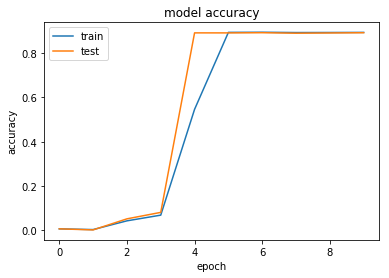

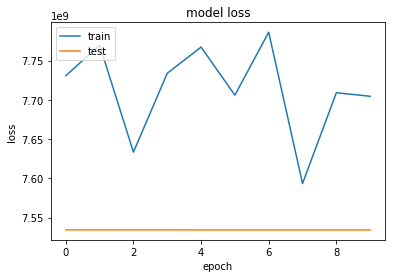

Running Fold 2 / 10
Train on 153681 samples, validate on 17075 samples
Epoch 1/10
153681/153681 [==============================] - 4s 26us/step - loss: 7796424786.7930 - acc: 0.8917 - val_loss: 7880923308.1759 - val_acc: 0.8964
Epoch 2/10
153681/153681 [==============================] - 4s 27us/step - loss: 7826732504.0910 - acc: 0.8918 - val_loss: 7880923365.7478 - val_acc: 0.8961
Epoch 3/10
153681/153681 [==============================] - 4s 26us/step - loss: 7815978837.1568 - acc: 0.8919 - val_loss: 7880923250.6040 - val_acc: 0.8969
Epoch 4/10
153681/153681 [==============================] - 4s 26us/step - loss: 7801869906.3899 - acc: 0.8923 - val_loss: 7880923250.6040 - val_acc: 0.8971
Epoch 5/10
153681/153681 [==============================] - 4s 26us/step - loss: 7893720066.1822 - acc: 0.8933 - val_loss: 7880923273.6328 - val_acc: 0.8970
Epoch 6/10
153681/153681 [==============================] - 4s 26us/step - loss: 7721813858.1532 - acc: 0.8931 - val_loss: 7880923227.5753 - val

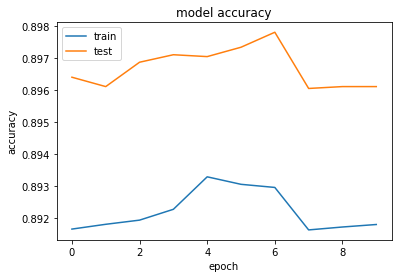

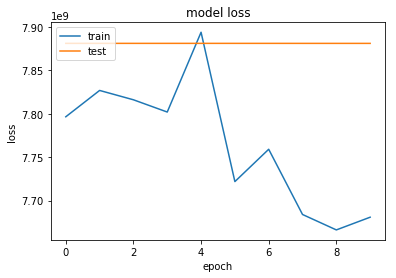

Running Fold 3 / 10
Train on 153681 samples, validate on 17075 samples
Epoch 1/10
153681/153681 [==============================] - 4s 26us/step - loss: 7723338398.7996 - acc: 0.8924 - val_loss: 7541919169.8404 - val_acc: 0.8982
Epoch 2/10
153681/153681 [==============================] - 4s 26us/step - loss: 7741526039.9607 - acc: 0.8952 - val_loss: 7541918502.8160 - val_acc: 0.8977
Epoch 3/10
153681/153681 [==============================] - 4s 26us/step - loss: 7750400427.9343 - acc: 0.8963 - val_loss: 7541918638.6797 - val_acc: 0.8996
Epoch 4/10
153681/153681 [==============================] - 4s 26us/step - loss: 7771955466.3429 - acc: 0.8960 - val_loss: 7541918692.3835 - val_acc: 0.8973
Epoch 5/10
153681/153681 [==============================] - 4s 26us/step - loss: 7698768430.1990 - acc: 0.8934 - val_loss: 7541918634.8116 - val_acc: 0.8954
Epoch 6/10
153681/153681 [==============================] - 4s 26us/step - loss: 7825255211.4521 - acc: 0.8934 - val_loss: 7541918518.1686 - val

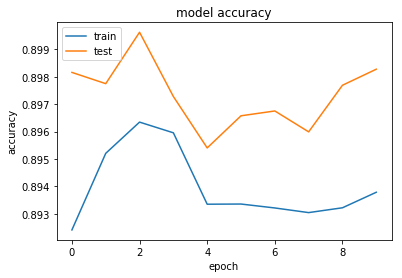

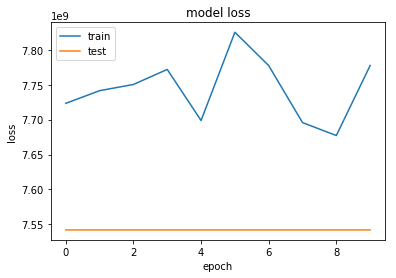

Running Fold 4 / 10
Train on 153681 samples, validate on 17075 samples
Epoch 1/10
153681/153681 [==============================] - 4s 26us/step - loss: 7758281030.3279 - acc: 0.8940 - val_loss: 7933529227.7917 - val_acc: 0.8953
Epoch 2/10
153681/153681 [==============================] - 4s 26us/step - loss: 7786446509.0654 - acc: 0.8946 - val_loss: 7933529333.7600 - val_acc: 0.8955
Epoch 3/10
153681/153681 [==============================] - 4s 28us/step - loss: 7654226031.4212 - acc: 0.8936 - val_loss: 7933529164.1028 - val_acc: 0.8931
Epoch 4/10
153681/153681 [==============================] - 4s 27us/step - loss: 7810260008.5853 - acc: 0.8927 - val_loss: 7933529164.8825 - val_acc: 0.8944
Epoch 5/10
153681/153681 [==============================] - 4s 26us/step - loss: 7631227462.1763 - acc: 0.8934 - val_loss: 7933529970.9489 - val_acc: 0.8947
Epoch 6/10
153681/153681 [==============================] - 4s 27us/step - loss: 7591826308.9449 - acc: 0.8947 - val_loss: 7933529235.4680 - val

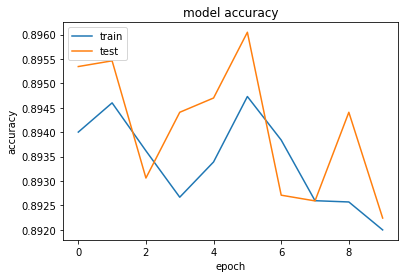

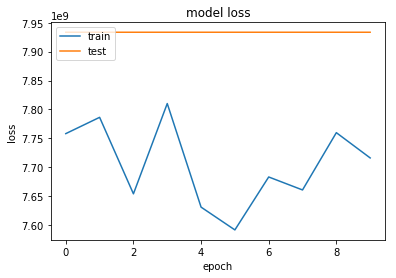

Running Fold 5 / 10
Train on 153681 samples, validate on 17075 samples
Epoch 1/10
153681/153681 [==============================] - 4s 26us/step - loss: 7680487550.6399 - acc: 0.8923 - val_loss: 7793756419.3734 - val_acc: 0.8857
Epoch 2/10
153681/153681 [==============================] - 4s 26us/step - loss: 7731055691.9200 - acc: 0.8923 - val_loss: 7793756309.5670 - val_acc: 0.8856
Epoch 3/10
153681/153681 [==============================] - 4s 26us/step - loss: 7876485601.7260 - acc: 0.8923 - val_loss: 7793756534.5171 - val_acc: 0.8852
Epoch 4/10
153681/153681 [==============================] - 4s 26us/step - loss: 7823527572.1219 - acc: 0.8920 - val_loss: 7793756502.2529 - val_acc: 0.8850
Epoch 5/10
153681/153681 [==============================] - 4s 26us/step - loss: 7705456577.0299 - acc: 0.8917 - val_loss: 7793756683.4244 - val_acc: 0.8848
Epoch 6/10
153681/153681 [==============================] - 4s 26us/step - loss: 7781421316.5526 - acc: 0.8920 - val_loss: 7793756448.5191 - val

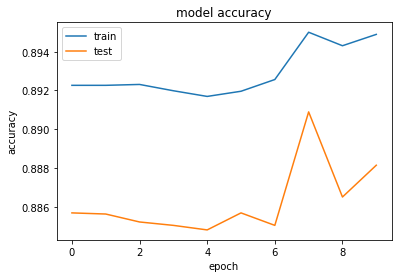

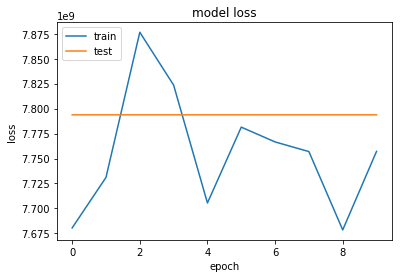

Running Fold 6 / 10
Train on 153681 samples, validate on 17075 samples
Epoch 1/10
153681/153681 [==============================] - 4s 26us/step - loss: 7659843771.1113 - acc: 0.8955 - val_loss: 7655221249.9191 - val_acc: 0.8922
Epoch 2/10
153681/153681 [==============================] - 4s 26us/step - loss: 7701808318.4196 - acc: 0.8924 - val_loss: 7655221193.8764 - val_acc: 0.8936
Epoch 3/10
153681/153681 [==============================] - 4s 26us/step - loss: 7758373886.0544 - acc: 0.8931 - val_loss: 7655221017.3226 - val_acc: 0.8935
Epoch 4/10
153681/153681 [==============================] - 4s 26us/step - loss: 7749406681.4503 - acc: 0.8931 - val_loss: 7655220970.4855 - val_acc: 0.8922
Epoch 5/10
153681/153681 [==============================] - 4s 26us/step - loss: 7722132851.5241 - acc: 0.8912 - val_loss: 7655221223.0522 - val_acc: 0.8925
Epoch 6/10
153681/153681 [==============================] - 4s 26us/step - loss: 7729632956.3573 - acc: 0.8911 - val_loss: 7655220978.9414 - val

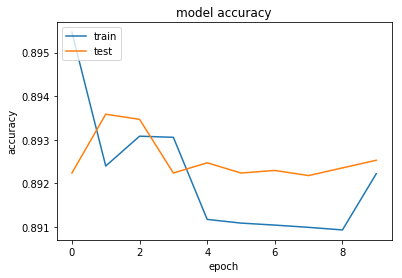

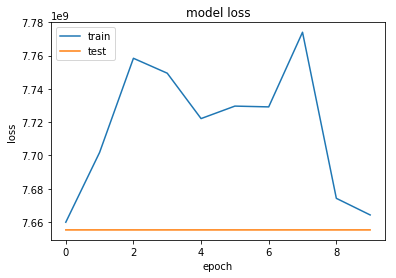

Running Fold 7 / 10
Train on 153681 samples, validate on 17075 samples
Epoch 1/10
153681/153681 [==============================] - 4s 26us/step - loss: 7743922362.9947 - acc: 0.8914 - val_loss: 7488478759.7306 - val_acc: 0.8914
Epoch 2/10
153681/153681 [==============================] - 4s 26us/step - loss: 7683922874.7632 - acc: 0.8913 - val_loss: 7488478825.7284 - val_acc: 0.8914
Epoch 3/10
153681/153681 [==============================] - 4s 26us/step - loss: 7704664224.2355 - acc: 0.8915 - val_loss: 7488479097.4857 - val_acc: 0.8916
Epoch 4/10
153681/153681 [==============================] - 4s 26us/step - loss: 7786338246.1105 - acc: 0.8911 - val_loss: 7488478714.4227 - val_acc: 0.8920
Epoch 5/10
153681/153681 [==============================] - 4s 26us/step - loss: 7790914209.6214 - acc: 0.8924 - val_loss: 7488478835.7135 - val_acc: 0.8924
Epoch 6/10
153681/153681 [==============================] - 4s 26us/step - loss: 7793739631.5895 - acc: 0.8918 - val_loss: 7488478517.8987 - val

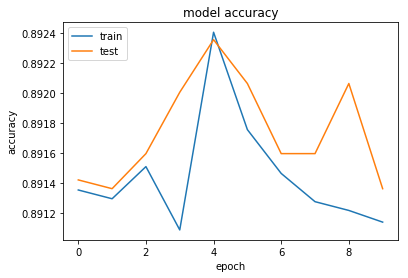

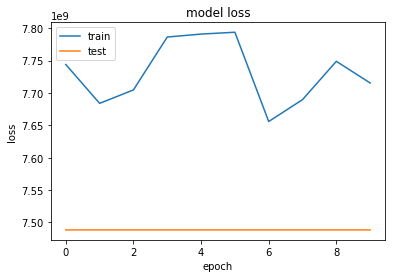

Running Fold 8 / 10
Train on 153681 samples, validate on 17075 samples
Epoch 1/10
153681/153681 [==============================] - 4s 26us/step - loss: 7767071864.5864 - acc: 0.8909 - val_loss: 7797562177.8928 - val_acc: 0.8945
Epoch 2/10
153681/153681 [==============================] - 4s 26us/step - loss: 7777884120.2176 - acc: 0.8909 - val_loss: 7797562142.5701 - val_acc: 0.8933
Epoch 3/10
153681/153681 [==============================] - 4s 26us/step - loss: 7657839778.4710 - acc: 0.8911 - val_loss: 7797561976.7510 - val_acc: 0.8962
Epoch 4/10
153681/153681 [==============================] - 4s 26us/step - loss: 7680098446.1950 - acc: 0.8916 - val_loss: 7797562285.3604 - val_acc: 0.8991
Epoch 5/10
153681/153681 [==============================] - 4s 26us/step - loss: 7686018215.3884 - acc: 0.8915 - val_loss: 7797562354.4466 - val_acc: 0.8944
Epoch 6/10
153681/153681 [==============================] - 4s 26us/step - loss: 7610190457.0928 - acc: 0.8909 - val_loss: 7797562389.7694 - val

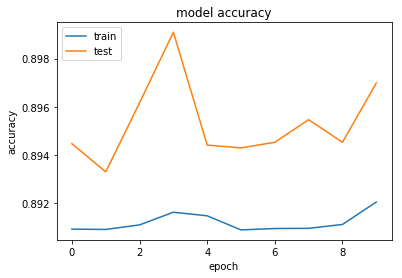

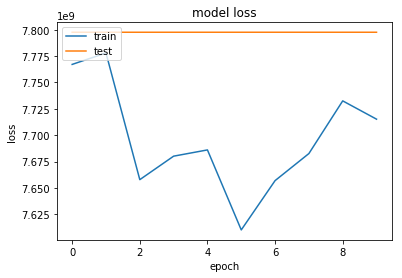

Running Fold 9 / 10
Train on 153681 samples, validate on 17075 samples
Epoch 1/10
153681/153681 [==============================] - 4s 26us/step - loss: 7721023751.6743 - acc: 0.8977 - val_loss: 7596308584.9787 - val_acc: 0.8895
Epoch 2/10
153681/153681 [==============================] - 4s 26us/step - loss: 7755758423.2357 - acc: 0.9576 - val_loss: 7596308228.0330 - val_acc: 0.9812
Epoch 3/10
153681/153681 [==============================] - 4s 26us/step - loss: 7712333308.9016 - acc: 0.9776 - val_loss: 7596307891.0576 - val_acc: 0.9790
Epoch 4/10
153681/153681 [==============================] - 4s 26us/step - loss: 7734589299.2675 - acc: 0.9756 - val_loss: 7596308855.1768 - val_acc: 0.9811
Epoch 5/10
153681/153681 [==============================] - 4s 26us/step - loss: 7710168844.3951 - acc: 0.9761 - val_loss: 7596307625.4473 - val_acc: 0.9808
Epoch 6/10
153681/153681 [==============================] - 4s 26us/step - loss: 7721106529.0655 - acc: 0.9795 - val_loss: 7596308024.6124 - val

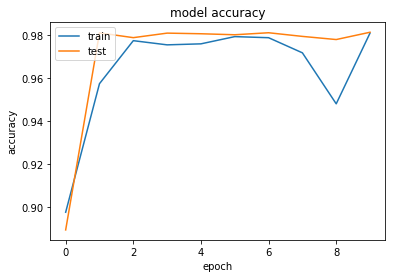

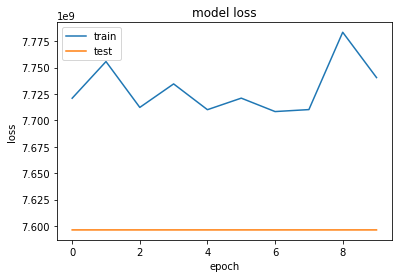

Running Fold 10 / 10
Train on 153681 samples, validate on 17075 samples
Epoch 1/10
153681/153681 [==============================] - 4s 26us/step - loss: 7760583446.1450 - acc: 0.9597 - val_loss: 7668396760.4943 - val_acc: 0.9800
Epoch 2/10
153681/153681 [==============================] - 4s 26us/step - loss: 7696775373.9181 - acc: 0.9726 - val_loss: 7668396599.2930 - val_acc: 0.9822
Epoch 3/10
153681/153681 [==============================] - 4s 26us/step - loss: 7654865313.4532 - acc: 0.9794 - val_loss: 7668396566.2192 - val_acc: 0.9831
Epoch 4/10
153681/153681 [==============================] - 4s 26us/step - loss: 7843228609.0832 - acc: 0.9722 - val_loss: 7668397157.3505 - val_acc: 0.9823
Epoch 5/10
153681/153681 [==============================] - 4s 26us/step - loss: 7684946158.5142 - acc: 0.9735 - val_loss: 7668397485.9001 - val_acc: 0.9442
Epoch 6/10
153681/153681 [==============================] - 4s 26us/step - loss: 7664554700.3123 - acc: 0.9697 - val_loss: 7668396876.2678 - va

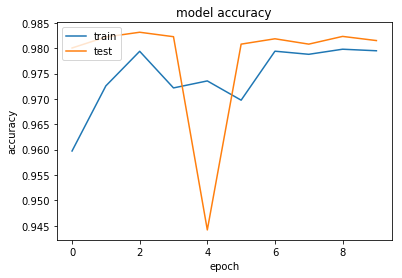

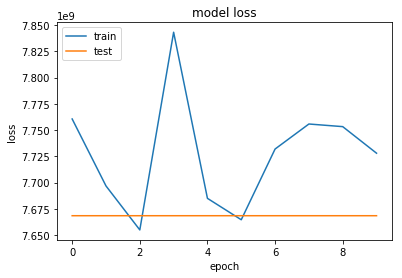

91.10% (+/- 3.54%)


In [172]:
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras import optimizers
import matplotlib.pyplot as plt
import keras.backend as K
from keras import losses


def my_own_loss():
        def port_loss(y_true, y_pred):
            x = K.square(y_pred - y_true)
            return K.mean(K.min(x-1,0)*x/(x-1) + K.max(x-1,0)*(2*x -1)/2/x/(x-1),axis=-1)
        
        def loss(y_true, y_pred):
            # Reconstruction loss
#             K.print_tensor(y_true, message='y_true = ')
#             print(K.get_value(y_pred))
            sip0_loss = 4 * K.mean(K.square(y_pred[0] - y_true[0]), axis=-1)
            sip1_loss = 3 * K.mean(K.square(y_pred[1] - y_true[1]), axis=-1)
            sip2_loss = 2 * K.mean(K.square(y_pred[2] - y_true[2]), axis=-1)
            sip3_loss = K.mean(K.square(y_pred[3] - y_true[3]), axis=-1)
            
            sip_loss = sip0_loss + sip1_loss + sip2_loss + sip3_loss 

            dip0_loss = 16 * K.mean(K.square(y_pred[4] - y_true[4]), axis=-1)
            dip1_loss = 9 * K.mean(K.square(y_pred[5] - y_true[5]), axis=-1)
            dip2_loss = 4 * K.mean(K.square(y_pred[6] - y_true[6]), axis=-1)
            dip3_loss = K.mean(K.square(y_pred[7] - y_true[7]), axis=-1)
            
            dip_loss = dip0_loss + dip1_loss + dip2_loss + dip3_loss 
            
            sport_loss = K.mean(K.square(y_pred[8] - y_true[8]), axis=-1)
#             sport_loss = K.mean(K.min(x-1,0)*x/(x-1) + K.max(x-1,0)*(2*x -1)/2/x/(x-1),axis=-1)
#             sport_loss = port_loss(y_true[8],y_pred[8])
            dport_loss = 4 * K.mean(K.square(y_pred[8] - y_true[8]), axis=-1)
#             protocol_loss = K.mean(K.square(y_true[10:17]-y_pred[10:17]),axis=-1)
            protocol_loss = K.categorical_crossentropy(y_true, y_pred)
            # Full loss
            
            model_loss = protocol_loss + sip_loss + dip_loss + sport_loss + dport_loss
            return model_loss

        return loss

# def custom_loss():

#     # Create a loss function that adds the MSE loss to the mean of all squared activations of a specific layer
#     def loss(y_true,y_pred):
#         return K.mean(K.square(y_pred - y_true), axis=-1)
#     return loss
    
x_train,x_test = train_test_split(result, test_size=0.2)
print(x_train.shape, x_test.shape)

input_d = Input(shape=(17,))
encoded = Dense(14, activation='relu')(input_d)
encoded = Dense(10, activation='relu')(encoded)
encoded = Dense(6, activation='relu')(encoded)
encoded = Dense(3, activation='relu')(encoded)

decoded = Dense(6, activation='relu')(encoded)
decoded = Dense(10, activation='relu')(decoded)
decoded = Dense(14, activation='relu')(decoded)
decoded = Dense(17, activation='sigmoid')(decoded)

autoencoder = Model(input_d, decoded)
# optimizer = optimizers.SGD(lr=0.1, momentum=0.0, decay=0.1)

autoencoder.compile(optimizer='RMSprop', loss=my_own_loss(),metrics=['accuracy'])

n_folds = 10
fold_len = int(len(x_train)/n_folds)
cross_validation_scores = []
for i in range(n_folds):
    print("Running Fold", i+1, "/", n_folds)
    fold_train = [k for k in range(0,i*fold_len)] + [k for k in range((i+1)*fold_len,len(x_train))]
    fold_test = [item for item in range(i*fold_len,(i+1)*fold_len)]
    test = x_train.iloc[fold_test]
    train = x_train.iloc[fold_train]
    history = autoencoder.fit(train, train,
            epochs=10,
            batch_size=256,
            shuffle=True,
            validation_data = (test,test))
    fold_validation_score = autoencoder.evaluate(test,test,verbose=0)
    print("fold validation score = ", fold_validation_score)
    cross_validation_scores.append(fold_validation_score[1] * 100)
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

print("%.2f%% (+/- %.2f%%)" % (np.mean(cross_validation_scores), np.std(cross_validation_scores)))
    
# autoencoder.fit(x_train, x_train,
#             epochs=100,
#             batch_size=256,
#             shuffle=True,
#             validation_split = 0.2)



In [173]:
test = autoencoder.evaluate(x=x_test,y=x_test, batch_size=256)
print(test)
print(x_test.shape)
# print(len(test))

42690/42690 [==============================] - 0s 12us/step
[7707873571.104802, 0.9801827125762659]
(42690, 17)


In [174]:
list_of_losses = []
batch_size = 10

batch_list = np.zeros((batch_size,17))
loss = autoencoder.evaluate(batch_list,batch_list,verbose=2,batch_size=batch_size)
print(loss)
zero_loss = float(loss[0] / batch_size)
print(zero_loss)
# batch_list = np.array(result.iloc[0]).reshape(1,-1)

batch_list = np.zeros((batch_size-1,17))
for index in range(0,result.shape[0]):
    input_row = np.array(result.iloc[index].values)
    input_row = input_row.reshape(1, -1)
    batch_list = np.append(batch_list,input_row,axis=0)
#     print(batch_list.shape)
    loss = autoencoder.evaluate(batch_list,batch_list,verbose=2,batch_size=batch_size)
    if index%1000 == 0:
        print(index)
    batch_list = np.zeros((batch_size-1,17))
    list_of_losses.append((index,loss[0]-(batch_size-1)*zero_loss))
print('list is ready to sort')

[4.330631256103516, 0.0]
0.43306312561035154
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
1520

In [188]:
list_of_losses.sort(key=lambda x: x[1], reverse=True)
print(list_of_losses[:10])

[(5251, 9497.125869369507), (8278, 9497.125869369507), (12699, 9489.593642807007), (1032, 9488.811416244507), (181639, 9384.995009994507), (193144, 9384.995009994507), (9913, 9284.390517807007), (453, 9265.345595932007), (9063, 9153.011611557007), (961, 9136.311416244507)]


In [184]:
print(result.iloc[5251])
print(df.iloc[5251])

out_df = pd.DataFrame(columns=df.columns)
out_list= []
index = 0
for i,j in list_of_losses:
    out_list.append(df.iloc[i])
    index += 1
    if index%1000 == 0:
        print(index)
# with open('out.txt', 'w') as f:
    
#     for i,j in list_of_losses:
#         f.write()

sip_0             192
sip_1             168
sip_2              20
sip_3             143
dip_0             192
dip_1             168
dip_2               1
dip_3             221
sport           61979
dport           62235
protocol_1          0
protocol_139        0
protocol_17         1
protocol_2          0
protocol_41         0
protocol_47         0
protocol_6          0
Name: 5251, dtype: int64
stime           2017-05-09 11:08:05.642
etime           2017-05-09 11:08:29.041
sip                      192.168.20.143
sport                             61979
sipint                       3232240783
mac                  00:1b:fc:6b:33:de:
osname                                 
osversion                              
fingerprint                            
dip                       192.168.1.221
dport                             62235
dipint                       3232235997
dstmac               00:0c:29:9b:f0:3c:
rosname                                
rosversion                             
r

In [194]:
# print(out_list[:10])
out_df = pd.DataFrame(out_list,columns=df.columns)
out_df
out_df.to_csv('./autoencoder_out_91_4_customLoss_2019_6_2.csv', encoding='utf-8')